# Supervised Learning - Gradient Boosting Classifier

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import where
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from collections import OrderedDict, Counter
from functools import reduce
from mlxtend.frequent_patterns import apriori, association_rules
import xgboost as xgb
from xgboost import XGBClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score,\
GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, roc_auc_score, f1_score, fbeta_score, classification_report,\
confusion_matrix, roc_curve, precision_score, recall_score, plot_confusion_matrix, precision_recall_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.feature_selection import chi2, f_regression, f_classif, mutual_info_classif,\
mutual_info_regression, SelectKBest, SelectFromModel, VarianceThreshold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import VotingClassifier

## Notes
* Classification on imbalanced datasets: https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23
    * https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/
* Metrics: https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
* There are problems where a class imbalance is not just common, it is expected. For example, in datasets like those that characterize fraudulent transactions are imbalanced. The vast majority of the transactions will be in the “Not-Fraud” class and a very small minority will be in the “Fraud” class. 
    * https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    * https://datascience.stackexchange.com/questions/36862/macro-or-micro-average-for-imbalanced-class-problems


## Data set up

In [2]:
train = pd.read_csv('Train_Clean_data.csv')

In [3]:
train_y = pd.read_csv('Train.csv')

In [4]:
combine = train.merge(train_y, on='Provider')

In [5]:
x = combine.drop(['Provider','PotentialFraud','DOD'], axis=1)
y = combine['PotentialFraud']
y = y.replace(['Yes','No'],[1,0])

In [6]:
pd.set_option('display.max_columns', False)
train.head()

,Provider,ClaimID,DOD,ClmAdmitDiagnosisCode,Inpatient,ClmProcedureCode,ClmProcedureCode_count,ClmDiagnosisCode_count,RenalDiseaseIndicator,duplicate,V5869_diag,V5861_diag,2724_diag,4011_diag,2449_diag,4019_diag,25000_diag,42731_diag,4019_proc,9904_proc,2724_proc,8154_proc,66_proc,3893_proc,3995_proc,4516_proc,3722_proc,8151_proc,8872_proc,5_state,10_state,33_state,45_state,14_state,39_state,Patient_Connections,AttPhys_Connections,InscClaimAmtReimbursed,DeductibleAmtPaid,treatment_days,Gender,IPAnnualReimbursementAmt,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,num_chronic,Age,claim_days
0,PRV51001,25,0,11,5.0,2.0,3.0,80.0,8.0,12,1,0,2,0,1,3,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,14.0,4185.600000,213.600000,1.000000,0.640000,17606.000000,12.000000,12.000000,897.120000,2615.200000,463.920000,5.560000,77.880000,1.440000
1,PRV51003,132,1,78,62.0,39.0,48.0,693.0,29.0,29,7,6,16,3,12,25,15,11,3,0,1,2,1,2,2,1,2,0,0,0,23,0,0,0,0,117.0,44.0,4588.409091,502.166667,2.424242,0.590909,7568.181818,11.818182,11.871212,931.424242,2678.181818,737.121212,4.545455,69.083333,3.674242
2,PRV51004,149,1,28,0.0,0.0,0.0,385.0,23.0,76,2,4,12,6,8,22,8,3,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,4,0,138.0,38.0,350.134228,2.080537,0.000000,0.691275,4351.879195,11.865772,11.959732,434.953020,2194.899329,622.751678,4.342282,71.261745,1.429530
3,PRV51005,1165,4,252,0.0,0.0,0.0,3016.0,259.0,565,56,47,73,62,30,140,54,23,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,495.0,7.0,241.124464,3.175966,0.000000,0.561373,3623.991416,11.907296,11.939914,379.162232,2109.733906,636.328755,4.335622,69.526180,1.088412
4,PRV51007,72,1,17,3.0,1.0,1.0,215.0,11.0,31,2,7,5,3,6,10,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58.0,10.0,468.194444,45.333333,0.222222,0.527778,3050.000000,11.833333,11.833333,445.000000,1729.722222,469.722222,4.166667,68.305556,0.958333


Drop PHY info

In [7]:
py_combine = combine.drop(['Provider','DOD'], axis=1)

In [8]:
counter = Counter(y)
print(counter)

Counter({0: 4904, 1: 506})


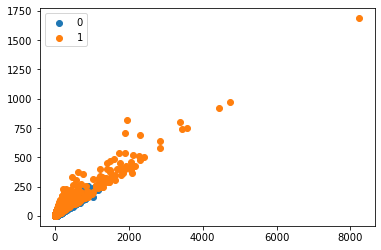

In [9]:
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter((x.iloc[row_ix,0]),(x.iloc[row_ix,1]), label=str(label))
plt.legend()
plt.show()

## Train Test Split 

Non stratify train_test_split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(x),y, test_size=0.3, random_state=42)

In [11]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 3440, 1: 347})
Counter({0: 1464, 1: 159})


Stratify during train_test_split for GBM

In [12]:
X_train,X_test,Y_train,Y_test = train_test_split(StandardScaler().fit_transform(x),y, test_size=0.3, random_state=42, stratify=y)

In [13]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3787, 48) (1623, 48) (3787,) (1623,)


In [14]:
print(Counter(Y_train))
print(Counter(Y_test))

Counter({0: 3433, 1: 354})
Counter({0: 1471, 1: 152})


# GBC 
Justification for no class_weight: 
* https://stackoverflow.com/questions/35539937/is-there-class-weight-or-alternative-way-for-gradientboostingclassifier-in-skl
* https://stackoverflow.com/questions/47399350/how-does-sample-weight-compare-to-class-weight-in-scikit-learn

<br> Other Models: https://pub.towardsai.net/imbalanced-learn-handling-imbalanced-class-problem-40aa3cb6525b

No adjustments. Goal is look at Precision

In [58]:
gbm_og = GradientBoostingClassifier()

In [59]:
gbm_og.fit(x_train,y_train)

GradientBoostingClassifier()

In [60]:
y_pred = gbm_og.predict(x_test)

In [61]:
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'Precision score: {precision_score(y_test,y_pred)}')
print(f'F1 score: {f1_score(y_test,y_pred)}')
print(f"F0.5 score: {fbeta_score(y_test, y_pred, average='binary', beta=0.5)}")
print(f"F2 score: {fbeta_score(y_test, y_pred, average='binary', beta=2)}")

Accuracy Score: 0.9254467036352434
Confusion Matrix: 
[[1436   28]
 [  93   66]]
Area Under Curve: 0.697984328281266
Recall score: 0.41509433962264153
Precision score: 0.7021276595744681
F1 score: 0.5217391304347826
F0.5 score: 0.6168224299065419
F2 score: 0.4520547945205479


Stratify train test split and Scale x values

In [35]:
gbm = GradientBoostingClassifier()

In [63]:
gbm.fit(X_train,Y_train)

gbc_predict_og = gbm.predict(X_test)

print(f'Accuracy Score: {accuracy_score(Y_test,gbc_predict_og)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, gbc_predict_og)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, gbc_predict_og)}')
print(f'Recall score: {recall_score(Y_test,gbc_predict_og)}')
print(f'Precision score: {precision_score(Y_test,gbc_predict_og)}')
print(f'F1 score: {f1_score(Y_test,gbc_predict_og)}')
print(f"F0.5 score: {fbeta_score(Y_test, gbc_predict_og, average='binary', beta=0.5)}")
print(f"F2 score: {fbeta_score(Y_test, gbc_predict_og, average='binary', beta=2)}")

Accuracy Score: 0.9322242760320394
Confusion Matrix: 
[[1428   43]
 [  67   85]]
Area Under Curve: 0.7649893556120075
Recall score: 0.5592105263157895
Precision score: 0.6640625
F1 score: 0.6071428571428572
F0.5 score: 0.6400602409638554
F2 score: 0.5774456521739131


### GBC - Feature Importance

In [31]:
sorted_importance = sorted(zip(x.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance

[('ClmProcedureCode_count', 0.2454520510761822),
 ('Inpatient', 0.23904854060019803),
 ('ClmProcedureCode', 0.0610026283770501),
 ('25000_diag', 0.05969096724683664),
 ('ClmAdmitDiagnosisCode', 0.05751341955412649),
 ('2724_diag', 0.03541461292591653),
 ('ClaimID', 0.02517479371966773),
 ('InscClaimAmtReimbursed', 0.024127733628798883),
 ('OPAnnualReimbursementAmt', 0.02303827642574658),
 ('DeductibleAmtPaid', 0.022023307582406282),
 ('42731_diag', 0.01919246823978975),
 ('claim_days', 0.016177492574222494),
 ('treatment_days', 0.015044560433326755),
 ('5_state', 0.013520671291554105),
 ('Gender', 0.012807820900545028),
 ('RenalDiseaseIndicator', 0.011239161471425277),
 ('OPAnnualDeductibleAmt', 0.009416333068512407),
 ('Age', 0.00819948298372277),
 ('Patient_Connections', 0.008011491353509401),
 ('AttPhys_Connections', 0.007214372221474608),
 ('45_state', 0.006782479296567118),
 ('NoOfMonths_PartBCov', 0.006570008923221493),
 ('14_state', 0.006486135754625448),
 ('duplicate', 0.006482

Text(0.5, 1.0, 'Feature Importance Plot of 500-Tree GBM')

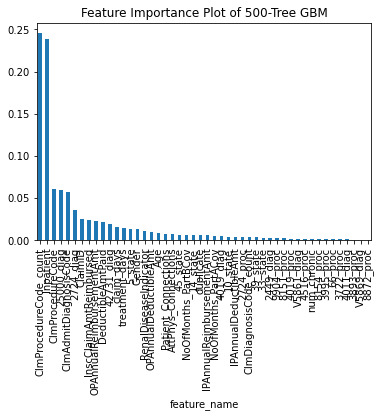

In [32]:
a, b = zip(*sorted_importance) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot of 500-Tree GBM')

### Hyper-parameter tuning - precision

In [65]:
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=gbm, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision')

grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.883503 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.000000 (0.000000) with: {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.000000 (0.000000) with: {'learning_rate': 0.0001

In [66]:
best_gbm = GradientBoostingClassifier(learning_rate = 0.01, max_depth=9, n_estimators=100, subsample=0.5)

In [67]:
best_gbm.fit(X_train,Y_train)

gbc_predict_best = best_gbm.predict(X_test)

print(f'Accuracy Score: {accuracy_score(Y_test,gbc_predict_best)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, gbc_predict_best)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, gbc_predict_best)}')
print(f'Recall score: {recall_score(Y_test,gbc_predict_best)}')
print(f'Precision score: {precision_score(Y_test,gbc_predict_best)}')
print(f'F1 score: {f1_score(Y_test,gbc_predict_best)}')
print(f"F0.5 score: {fbeta_score(Y_test, gbc_predict_best, average='binary', beta=0.5)}")
print(f"F2 score: {fbeta_score(Y_test, gbc_predict_best, average='binary', beta=2)}")

Accuracy Score: 0.9297597042513863
Confusion Matrix: 
[[1465    6]
 [ 108   44]]
Area Under Curve: 0.6426974131453719
Recall score: 0.2894736842105263
Precision score: 0.88
F1 score: 0.4356435643564356
F0.5 score: 0.6250000000000001
F2 score: 0.33434650455927056


### Hyper-parameter tuning - F1

In [98]:
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_f = GridSearchCV(estimator=gbm, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro')

grid_result_f = grid_search_f.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result_f.best_score_, grid_result_f.best_params_))

Best: 0.753141 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}


In [37]:
best_gbm_f = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 50, subsample= 0.7)
best_gbm_f.fit(X_train, Y_train)

gbm_f_predict = best_gbm_f.predict(X_test)

print(f'Accuracy Score: {accuracy_score(Y_test, gbm_f_predict)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, gbm_f_predict)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, gbm_f_predict)}')
print(f'Recall score: {recall_score(Y_test, gbm_f_predict)}')
print(f'Precision score: {precision_score(Y_test, gbm_f_predict)}')
print(f'F1 score: {f1_score(Y_test, gbm_f_predict)}')
print(f"F0.5 score: {fbeta_score(Y_test, gbm_f_predict, average='binary', beta=0.5)}")
print(f"F2 score: {fbeta_score(Y_test, gbm_f_predict, average='binary', beta=2)}")

Accuracy Score: 0.9383857054836722
Confusion Matrix: 
[[1436   35]
 [  65   87]]
Area Under Curve: 0.7742875415936168
Recall score: 0.5723684210526315
Precision score: 0.7131147540983607
F1 score: 0.635036496350365
F0.5 score: 0.6796874999999999
F2 score: 0.595890410958904


In [38]:
sorted_importance = sorted(zip(x.columns, best_gbm_f.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance

[('Inpatient', 0.31451432855213385),
 ('ClmProcedureCode_count', 0.17930059686189453),
 ('25000_diag', 0.056637293544317395),
 ('ClmProcedureCode', 0.04942740893027652),
 ('2724_diag', 0.04265789787853578),
 ('42731_diag', 0.03530201557164503),
 ('ClmAdmitDiagnosisCode', 0.029823907758720784),
 ('ClaimID', 0.02300114997238317),
 ('claim_days', 0.01962521610588508),
 ('OPAnnualReimbursementAmt', 0.019307521900252825),
 ('InscClaimAmtReimbursed', 0.016974283485209442),
 ('Patient_Connections', 0.0158435826723579),
 ('DeductibleAmtPaid', 0.015485399804652347),
 ('treatment_days', 0.014068580550197942),
 ('Gender', 0.013025422392912635),
 ('Age', 0.012826011032266339),
 ('2449_diag', 0.011159972550036803),
 ('4019_proc', 0.010054533438915384),
 ('RenalDiseaseIndicator', 0.008876445392097091),
 ('duplicate', 0.008818862015672823),
 ('V5869_diag', 0.008787638245840144),
 ('NoOfMonths_PartACov', 0.008660652433545784),
 ('ClmDiagnosisCode_count', 0.00850738973177339),
 ('45_state', 0.007539662

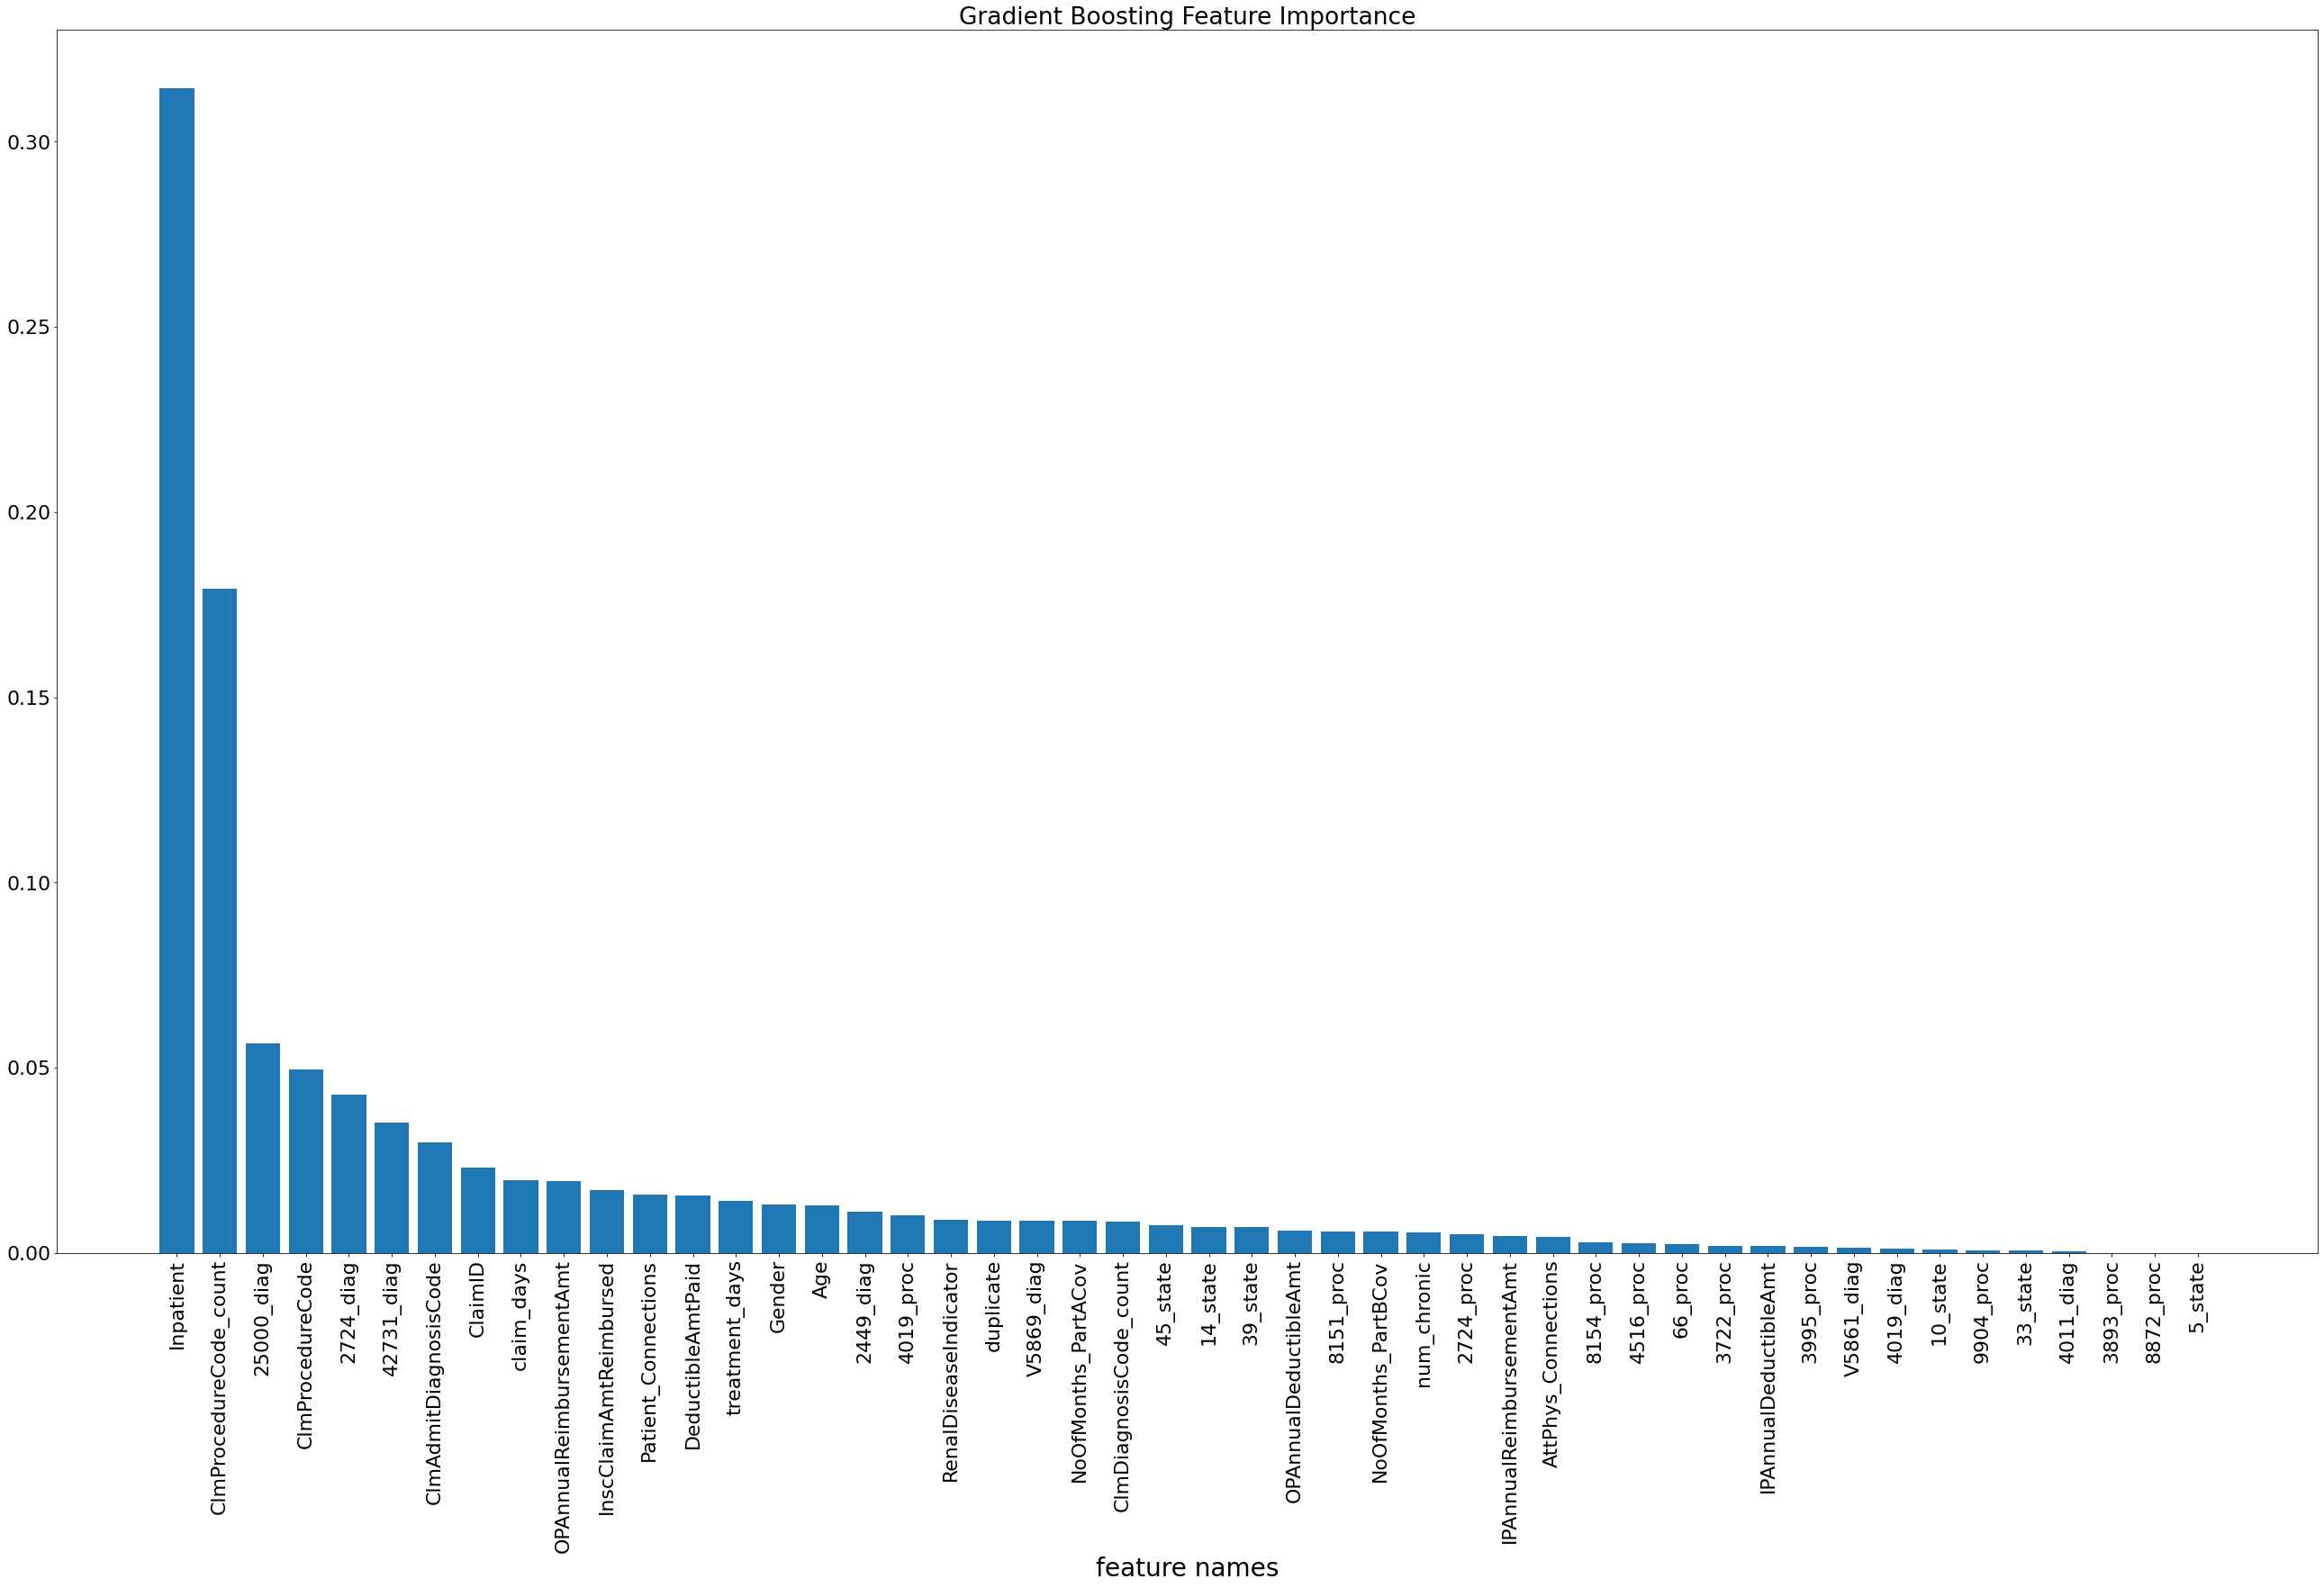

In [65]:
a, b = zip(*sorted_importance)
plt.figure(figsize=(45,25))
plt.bar(a,b)
plt.xticks(rotation='vertical')
plt.xlabel('feature names',fontsize=28)
plt.title("Gradient Boosting Feature Importance")
plt.rcParams.update({'font.size':22})
plt.show()

# VotingClassifier

In [91]:
from sklearn.ensemble import VotingClassifier

In [95]:
kfold = model_selection.KFold(n_splits=10, random_state = 7)
estimators = []

LogReg = LogisticRegression(random_state=13,C=1.0,fit_intercept=True, penalty='l1',solver='liblinear',class_weight={0: 1.0, 1: 1}, max_iter=2000)
estimators.append(('logistic', LogReg))
RandFor = RandomForestClassifier(class_weight = 'balanced', random_state=0)
estimators.append(('random forest', RandFor))
GBC = GradientBoostingClassifier(learning_rate = 0.01, max_depth=9, n_estimators=100, subsample=0.5)
estimators.append(('gradient boosting classifier', GBC))


ensemble = VotingClassifier(estimators)

results= model_selection.cross_val_score(ensemble, X_train, Y_train, cv=kfold, scoring='f1_macro')
print(np.mean(results))



/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.7310466600963178


In [96]:
vc = ensemble.fit(X_train, Y_train)

In [97]:
vc_predict = vc.predict(X_test)

print(f'Accuracy Score: {accuracy_score(Y_test,vc_predict)}')
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, vc_predict)}')
print(f'Area Under Curve: {roc_auc_score(Y_test, vc_predict)}')
print(f'Recall score: {recall_score(Y_test,vc_predict)}')
print(f'Precision score: {precision_score(Y_test,vc_predict)}')
print(f'F1 score: {f1_score(Y_test,vc_predict)}')
print(f"F0.5 score: {fbeta_score(Y_test, vc_predict, average='binary', beta=0.5)}")
print(f"F2 score: {fbeta_score(Y_test, vc_predict, average='binary', beta=2)}")

Accuracy Score: 0.9359211337030191
Confusion Matrix: 
[[1450   21]
 [  83   69]]
Area Under Curve: 0.719835682850907
Recall score: 0.45394736842105265
Precision score: 0.7666666666666667
F1 score: 0.5702479338842976
F0.5 score: 0.673828125
F2 score: 0.49426934097421205


# More Testing with Different Models
# XGBoost
Example: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [18]:
xg_model = xgb.XGBClassifier()

In [19]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
xg_model.fit(x_train, y_train)
xg_rocauc = cross_val_score(xg_model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
xg_f1 = cross_val_score(xg_model, x_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
xg_precision = cross_val_score(xg_model, x_train, y_train, scoring='precision', cv=cv, n_jobs=-1)
xg_recall = cross_val_score(xg_model, x_train, y_train, scoring='recall', cv=cv, n_jobs=-1)

/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:51:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


With Diagnostic codes

In [20]:
print('ROC_AUC: %.5f' % np.mean(xg_rocauc))
print('F1: %.5f' % np.mean(xg_f1))
print('Precision: %.5f' % np.mean(xg_precision))
print('Recall: %.5f' % np.mean(xg_recall))

ROC_AUC: 0.92372
F1: 0.53540
Precision: 0.65447
Recall: 0.45947


No Diagnostic codes

In [29]:
print('ROC_AUC: %.5f' % np.mean(xg_rocauc))
print('F1: %.5f' % np.mean(xg_f1))
print('Precision: %.5f' % np.mean(xg_precision))
print('Recall: %.5f' % np.mean(xg_recall))

ROC_AUC: 0.92596
F1: 0.56132
Precision: 0.67953
Recall: 0.48437


In [20]:
estimate = list(counter.values())[0] / list(counter.values())[1]
print('Estimate: %.3f' % estimate)

Estimate: 9.692


Adjusted scale_pos_weight

In [21]:
xg_model_high = xgb.XGBClassifier(scale_pos_weight=9)
xg_model_high.fit(x_train, y_train)
xg_rocauc_high = cross_val_score(xg_model_high, x_train, y_train, scoring='roc_auc', n_jobs=-1)
xg_f1_high = cross_val_score(xg_model_high, x_train, y_train, scoring='f1', n_jobs=-1)
xg_precision_high = cross_val_score(xg_model_high, x_train, y_train, scoring='precision', n_jobs=-1)
xg_recall_high = cross_val_score(xg_model_high, x_train, y_train, scoring='recall', n_jobs=-1)

/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:53:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


With diagnostic codes

In [22]:
print('ROC_AUC: %.5f' % np.mean(xg_rocauc_high))
print('F1: %.5f' % np.mean(xg_f1_high))
print('Precision: %.5f' % np.mean(xg_precision_high))
print('Recall: %.5f' % np.mean(xg_recall_high))

ROC_AUC: 0.92560
F1: 0.59195
Precision: 0.61898
Recall: 0.57052


No diagnostic code

In [27]:
print('ROC_AUC: %.5f' % np.mean(xg_rocauc_high))
print('F1: %.5f' % np.mean(xg_f1_high))
print('Precision: %.5f' % np.mean(xg_precision_high))
print('Recall: %.5f' % np.mean(xg_recall_high))

ROC_AUC: 0.92391
F1: 0.57845
Precision: 0.61178
Recall: 0.55337


In [23]:
print(confusion_matrix(y_test,xg_model_high.predict(x_test)))
print(classification_report(y_test,xg_model_high.predict(x_test)))

[[1421   43]
 [  77   82]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1464
           1       0.66      0.52      0.58       159

    accuracy                           0.93      1623
   macro avg       0.80      0.74      0.77      1623
weighted avg       0.92      0.93      0.92      1623



Confusion matrix, without normalization
[[1412   52]
 [  74   85]]
Normalized confusion matrix
[[0.96448087 0.03551913]
 [0.46540881 0.53459119]]


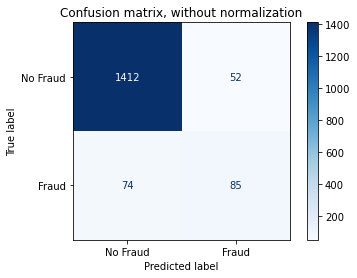

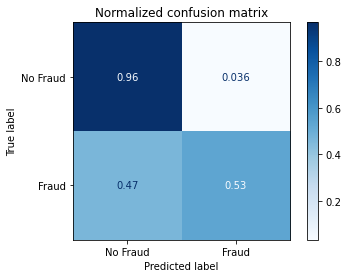

In [51]:
title_options = [("Confusion matrix, without normalization", None),\
                ("Normalized confusion matrix", 'true')]

for title, normalize in title_options:
    disp = plot_confusion_matrix(xg_model_, x_test, Y_test, normalize=normalize, cmap=plt.cm.Blues, display_labels=['No Fraud','Fraud'])
    
    disp.ax_.set_title(title)
    
    print(title)
    print(disp.confusion_matrix)
    
plt.show()

In [60]:
def plot_cm(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax= plt.subplot()
    sns.heatmap(cm/np.sum(cm), annot=labels, ax = ax, fmt='', cmap = "Blues"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix with %s' % model)
    ax.xaxis.set_ticklabels(['Not Fraud', 'Potential Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Potential Fraud'])

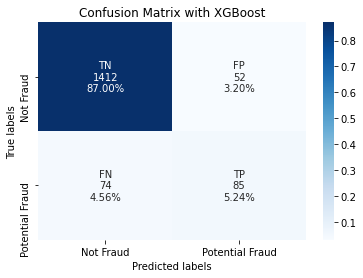

In [61]:
plot_cm(Y_test, xg_model.predict(x_test),'XGBoost')

In [63]:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = xg_model.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

In [64]:
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
print('No Fraud: ROC AUC=%.3f' % (ns_auc))
print('Fraud: ROC AUC=%.3f' % (lr_auc))

No Fraud: ROC AUC=0.500
Fraud: ROC AUC=0.924


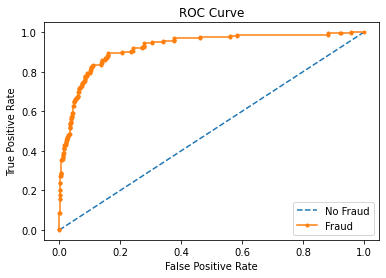

In [73]:
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--',label='No Fraud')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Fraud')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.show()

Fraud: f1=0.574 auc=0.663


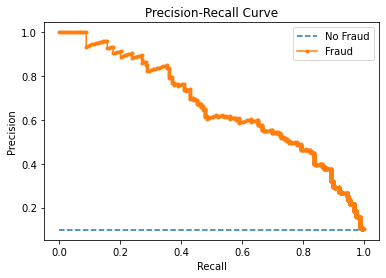

In [74]:
yhat = xg_model.predict(x_test)
lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
lr_f1, lr_auc = f1_score(Y_test, yhat), auc(lr_recall, lr_precision)

print('Fraud: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

no_fraud = len(Y_test[Y_test==1])/len(Y_test)
plt.plot([0,1], [no_fraud, no_fraud], linestyle='--',label='No Fraud')
plt.plot(lr_recall, lr_precision, marker='.', label='Fraud')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


### XGBoost Parameters

In [21]:
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000]
min_child_weight = [1,5,10,15,25]
param_grid = dict(scale_pos_weight=weights,min_child_weight=min_child_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=xg_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(x_train,Y_train)

/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.930197 using {'min_child_weight': 25, 'scale_pos_weight': 1}
0.921523 (0.020223) with: {'min_child_weight': 1, 'scale_pos_weight': 0.01}
0.929532 (0.021655) with: {'min_child_weight': 1, 'scale_pos_weight': 0.1}
0.925961 (0.021222) with: {'min_child_weight': 1, 'scale_pos_weight': 1}
0.922040 (0.023926) with: {'min_child_weight': 1, 'scale_pos_weight': 10}
0.918061 (0.021962) with: {'min_child_weight': 1, 'scale_pos_weight': 25}
0.917537 (0.024578) with: {'min_child_weight': 1, 'scale_pos_weight': 50}
0.918103 (0.020443) with: {'min_child_weight': 1, 'scale_pos_weight': 75}
0.914079 (0.025273) with: {'min_child_weight': 1, 'scale_pos_weight': 99}
0.914129 (0.022128) with: {'min_child_weight': 1, 'scale_pos_weight': 100}
0.903502 (0.022847) with: {'min_child_weight': 1, 'scale_pos_weight': 1000}
0.893310 (0.023556) with: {'min_child_weight': 5, 'scale_pos_weight': 0.01}
0.929223 (0.018005) with: {'min_child_weight': 5, 'scale_pos_weight': 0.1}
0.925039 (0.022895) with: {'min_chi

In [52]:
grid

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=9, subsample=1,
                          

# SVM
https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

**Adjust built-in parameter**

In [24]:
svc_model_p = SVC(class_weight='balanced', probability=True)

In [25]:
counter_over = Counter(y_train)
print(counter_over)

Counter({0: 3440, 1: 347})


In [26]:
svc_model_p.fit(x_train,y_train)

SVC(class_weight='balanced', probability=True)

In [27]:
svc_predict = svc_model_p.predict(x_test)

In [28]:
print('ROCAUC score:', roc_auc_score(y_test, svc_predict))
print('Accuracy score:', accuracy_score(y_test, svc_predict))
print('F1 score:', f1_score(y_test, svc_predict))
print('Precision score:', precision_score(y_test, svc_predict))
print('Recall score:', recall_score(y_test,svc_predict))

ROCAUC score: 0.8464339107124447
Accuracy score: 0.884781269254467
F1 score: 0.5759637188208616
Precision score: 0.450354609929078
Recall score: 0.7987421383647799


**With SMOTE - oversampling**

In [29]:
oversample = SMOTE()
x_train_over, y_train_over = oversample.fit_resample(x_train,y_train)

In [30]:
svc_model_smote = SVC()

In [31]:
svc_model_smote.fit(x_train_over,y_train_over)

SVC()

In [32]:
svc_predict_smote = svc_model_smote.predict(x_test)

In [33]:
print('ROCAUC score:', roc_auc_score(y_test, svc_predict_smote))
print('Accuracy score:', accuracy_score(y_test, svc_predict_smote))
print('F1 score:', f1_score(y_test, svc_predict_smote))
print('Precision score:', precision_score(y_test, svc_predict_smote))
print('Recall score:', recall_score(y_test,svc_predict_smote))

ROCAUC score: 0.8497203319929889
Accuracy score: 0.8755391250770179
F1 score: 0.5627705627705628
Precision score: 0.429042904290429
Recall score: 0.8176100628930818


# Test All Models

In [47]:
from pycaret.classification import *

In [48]:
clf1 = setup(data = py_combine, target = 'PotentialFraud')

,Description,Value
0,session_id,5650
1,Target,PotentialFraud
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(5410, 50)"
5,Missing Values,False
6,Numeric Features,38
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [133]:
compare_models(verbose=False, turbo=False, n_select=10, sort='F1')

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=3804, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=3804),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
 

# Compare Models
* https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
* Reasons for choosing macro: https://datascience.stackexchange.com/questions/36862/macro-or-micro-average-for-imbalanced-class-problems

In [66]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
              ('LogReg', LogisticRegression()), 
              ('RF', RandomForestClassifier()),
              ('SVM', SVC()), 
              ('XGB', XGBClassifier()),
              ('GBC', GradientBoostingClassifier()),
              ('KNN', KNeighborsClassifier())
            ]
    results = []
    names = []
    scoring = ['f1_macro','precision_macro','recall_macro']
    target_names = ['no fraud', 'fraud']
    
    for name, model in models:
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    return final

In [67]:
final = run_exps(X_train,Y_train,X_test,Y_test)

/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

LogReg
              precision    recall  f1-score   support

    no fraud       0.95      0.98      0.97      1471
       fraud       0.75      0.52      0.61       152

    accuracy                           0.94      1623
   macro avg       0.85      0.75      0.79      1623
weighted avg       0.93      0.94      0.93      1623

RF
              precision    recall  f1-score   support

    no fraud       0.95      0.98      0.96      1471
       fraud       0.70      0.51      0.59       152

    accuracy                           0.93      1623
   macro avg       0.83      0.74      0.78      1623
weighted avg       0.93      0.93      0.93      1623

SVM
              precision    recall  f1-score   support

    no fraud       0.95      0.98      0.96      1471
       fraud       0.73      0.48      0.58       152

    accuracy                           0.93      1623
   macro avg       0.84      0.73      0.77      1623
weighted avg       0.93      0.93      0.93      1623

[11:5

/Users/thisbekristin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:56:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

In [68]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

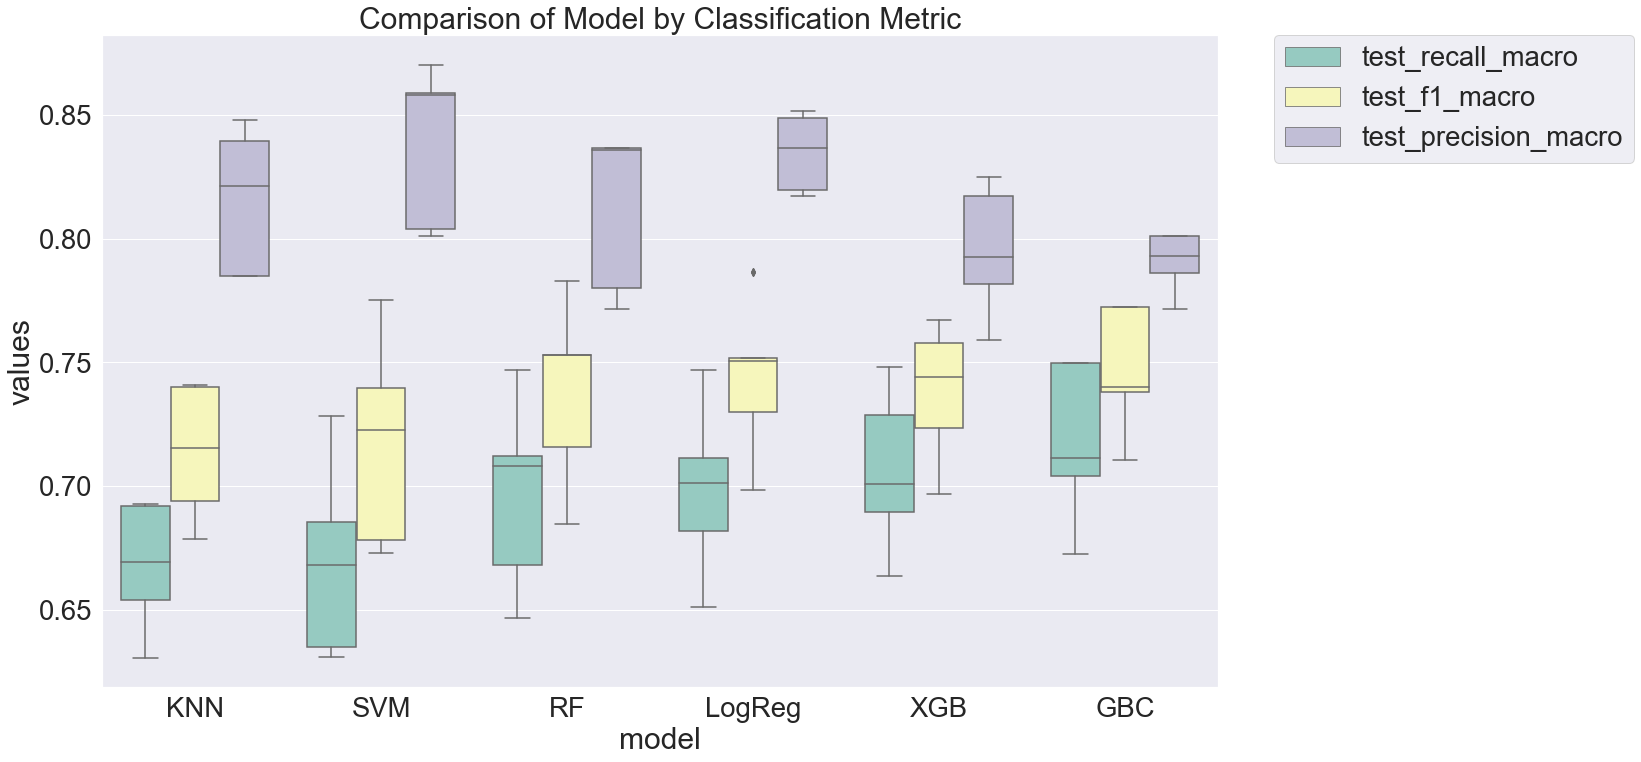

In [69]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

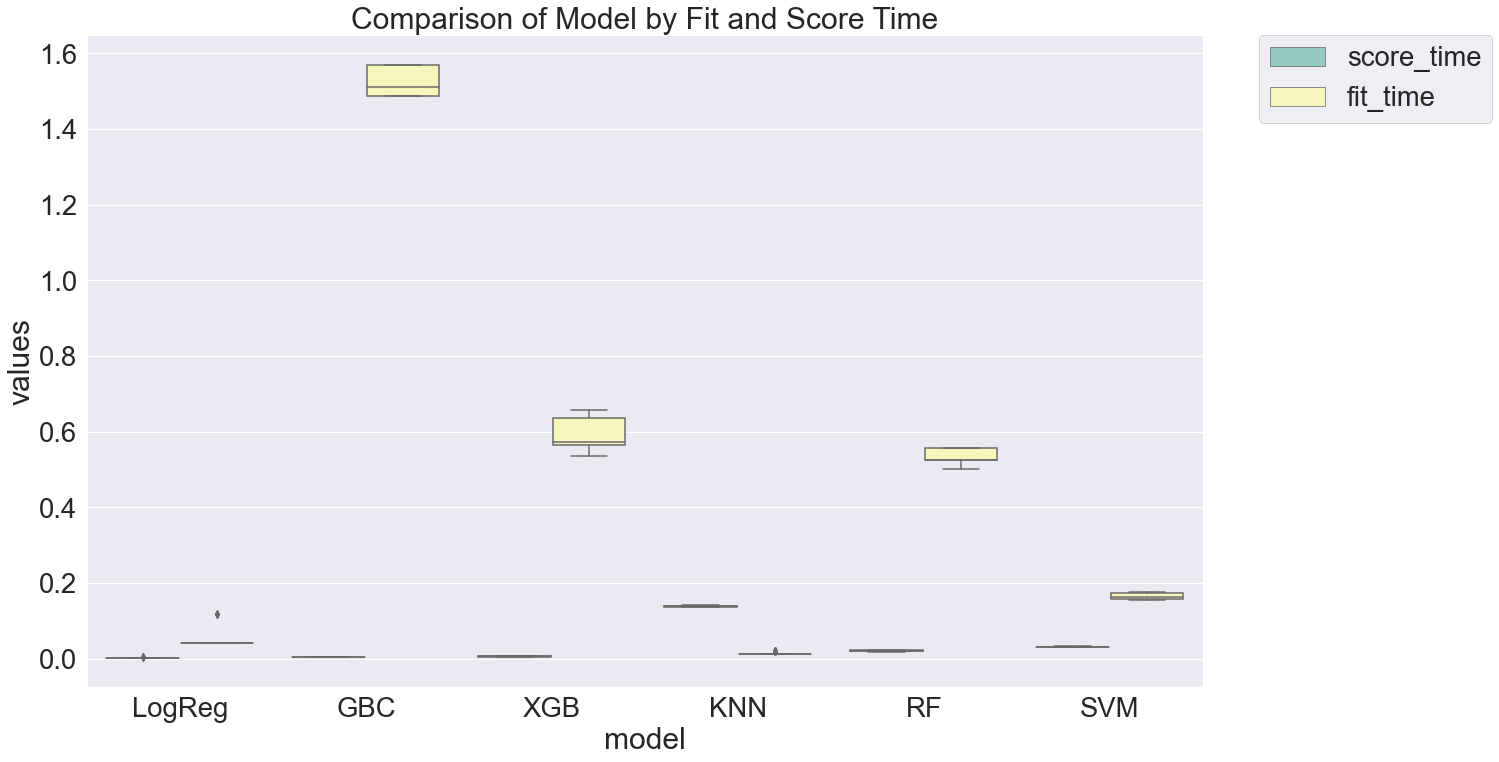

In [70]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [71]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_precision_macro           test_recall_macro           test_f1_macro          
                        std      mean               std      mean           std      mean
model                                                                                    
GBC                0.010572  0.790292          0.025893  0.715991      0.020113  0.745020
KNN                0.025169  0.818149          0.021477  0.666868      0.023339  0.711817
LogReg             0.013151  0.834371          0.026018  0.696004      0.023511  0.741360
RF                 0.029275  0.814412          0.036098  0.696746      0.035278  0.736775
SVM                0.029103  0.839302          0.036818  0.673083      0.038997  0.721236
XGB                0.023510  0.791912          0.027006  0.700651      0.024014  0.734250